In [1]:
# coding: utf-8
import os

import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

from mydatools.features_analyze import get_top_k_corr

% matplotlib inline

## Config

In [2]:
trn_path = './data/input/train.csv'
tst_path = './data/input/test.csv'
id_col = 'id'
label_col = 'target'

submission_path = './data/output/submission.csv'
output_id_col = id_col
output_label_col = label_col

## Load Data

In [3]:
trn_df = pd.read_csv(trn_path)
trn_df['ds_type'] = 'train'

tst_df = pd.read_csv(tst_path)
tst_df['ds_type'] = 'test'

full_df = pd.concat([trn_df, tst_df])

del(trn_df)
del(tst_df)

full_df.head()

,ds_type,id,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,...,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,target
0,train,7,0.6,0.5,0.2,3,1,10,1,10,...,0,0,11,0,1,0,0.7,0.2,0.718070,0.0
1,train,9,0.3,0.1,0.3,2,1,9,5,8,...,0,0,3,0,0,1,0.8,0.4,0.766078,0.0
2,train,13,0.5,0.7,0.1,2,2,9,1,8,...,0,0,12,1,0,0,0.0,0.0,-1.000000,0.0
3,train,16,0.6,0.9,0.1,2,4,7,1,8,...,0,0,8,1,0,0,0.9,0.2,0.580948,0.0
4,train,17,0.4,0.6,0.0,2,2,6,3,10,...,0,0,9,1,0,0,0.7,0.6,0.840759,0.0


In [4]:
# dataset type
is_train = full_df['ds_type'] == 'train'
is_test = full_df['ds_type'] == 'test'

## Features

In [5]:
a = [11,22,33,44]
a.remove(33)
33 in a

False

In [6]:
feature_columns = []

def add_features(features):
    if not isinstance(features, list):
        features = [features]
    global feature_columns
    feature_columns.extend([f for f in features if f not in feature_columns])
    
def remove_features(features):
    if not isinstance(features, list):
        features = [features]
    global feature_columns
    feature_columns = [f for f in feature_columns if f not in features]

In [7]:
numerical_features = full_df.dtypes[full_df.dtypes != 'object'].index.tolist()
numerical_features = [c for c in numerical_features if c not in [id_col, label_col, 'ds_type']]
add_features(numerical_features)

* 空值处理

In [8]:
full_df.replace(-1, np.nan, inplace=True)

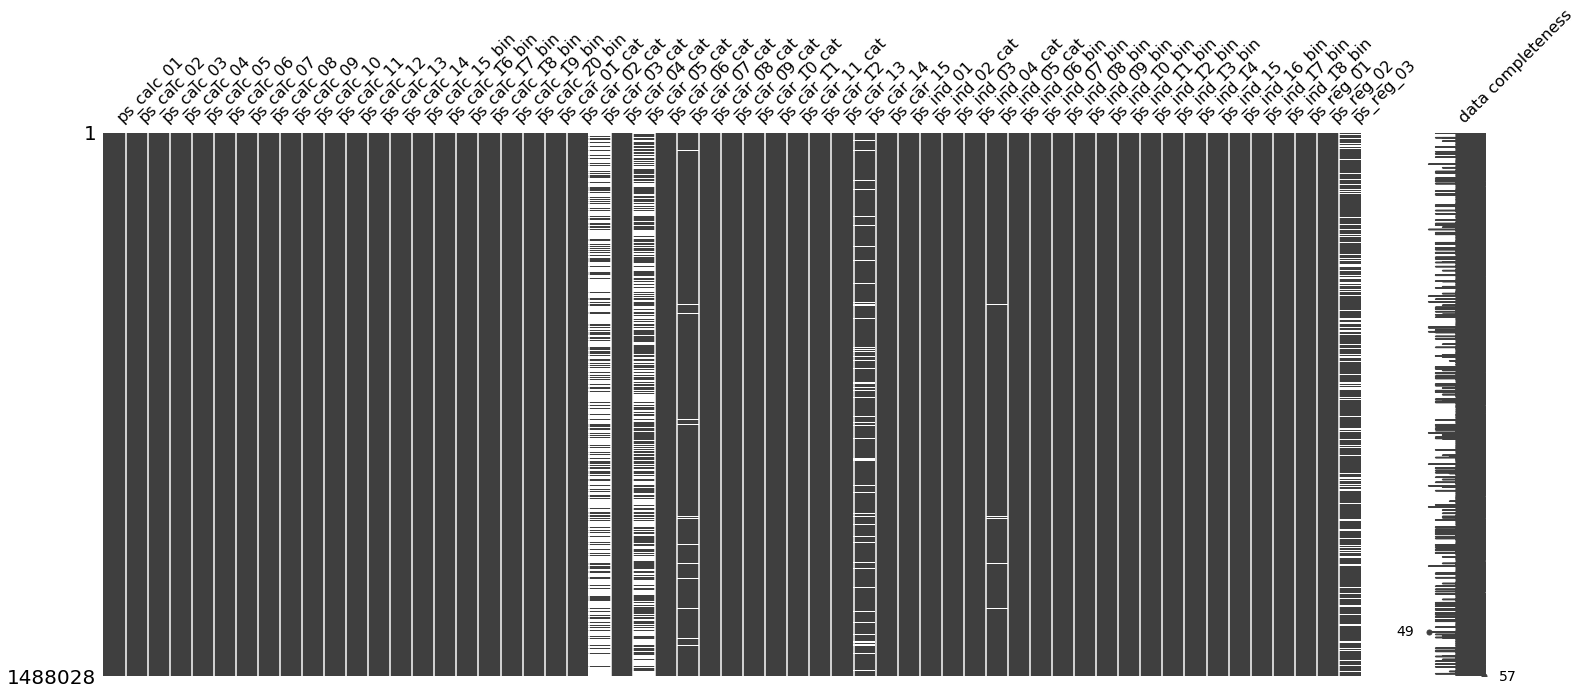

In [9]:
import missingno as msno
msno.matrix(full_df[feature_columns], labels=True)

* 处理categorical类型特征

In [10]:
categorical_features = [c for c in feature_columns if c.endswith('cat')]

In [11]:
dummy_df = pd.get_dummies(full_df[categorical_features], columns=categorical_features)
remove_features(categorical_features)
add_features(dummy_df.columns.tolist())
full_df[dummy_df.columns] = dummy_df

## LightGBM

In [12]:
trn_df = full_df[is_train]
tst_df = full_df[is_test]

X = trn_df[feature_columns]
y = trn_df[label_col]
X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

X_tst = tst_df[feature_columns]

trn_lgb = lgb.Dataset(X_trn.values, y_trn)
val_lgb = lgb.Dataset(X_val.values, y_val, reference=trn_lgb)

In [13]:
params = {
    'application': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.05,
    'is_unbalance': True,
    'seed': 0,
}
bst = lgb.train(params, trn_lgb, 1000, valid_sets=[trn_lgb, val_lgb], early_stopping_rounds=20)

[1]	training's binary_logloss: 0.690977	valid_1's binary_logloss: 0.691041
Training until validation scores don't improve for 20 rounds.
[2]	training's binary_logloss: 0.689011	valid_1's binary_logloss: 0.689134
[3]	training's binary_logloss: 0.687189	valid_1's binary_logloss: 0.687366
[4]	training's binary_logloss: 0.685516	valid_1's binary_logloss: 0.685758
[5]	training's binary_logloss: 0.683946	valid_1's binary_logloss: 0.684228
[6]	training's binary_logloss: 0.682486	valid_1's binary_logloss: 0.682812
[7]	training's binary_logloss: 0.681111	valid_1's binary_logloss: 0.681478
[8]	training's binary_logloss: 0.679834	valid_1's binary_logloss: 0.68025
[9]	training's binary_logloss: 0.678652	valid_1's binary_logloss: 0.679111
[10]	training's binary_logloss: 0.677553	valid_1's binary_logloss: 0.678071
[11]	training's binary_logloss: 0.676535	valid_1's binary_logloss: 0.677084
[12]	training's binary_logloss: 0.675533	valid_1's binary_logloss: 0.676132
[13]	training's binary_logloss: 0.67

[110]	training's binary_logloss: 0.644235	valid_1's binary_logloss: 0.64753
[111]	training's binary_logloss: 0.644073	valid_1's binary_logloss: 0.647422
[112]	training's binary_logloss: 0.643904	valid_1's binary_logloss: 0.647275
[113]	training's binary_logloss: 0.643719	valid_1's binary_logloss: 0.647118
[114]	training's binary_logloss: 0.64357	valid_1's binary_logloss: 0.64699
[115]	training's binary_logloss: 0.643374	valid_1's binary_logloss: 0.64681
[116]	training's binary_logloss: 0.643204	valid_1's binary_logloss: 0.646669
[117]	training's binary_logloss: 0.643052	valid_1's binary_logloss: 0.646525
[118]	training's binary_logloss: 0.642892	valid_1's binary_logloss: 0.646383
[119]	training's binary_logloss: 0.64273	valid_1's binary_logloss: 0.646262
[120]	training's binary_logloss: 0.6426	valid_1's binary_logloss: 0.646168
[121]	training's binary_logloss: 0.642449	valid_1's binary_logloss: 0.646044
[122]	training's binary_logloss: 0.642288	valid_1's binary_logloss: 0.645909
[123]	

[221]	training's binary_logloss: 0.628563	valid_1's binary_logloss: 0.634361
[222]	training's binary_logloss: 0.628422	valid_1's binary_logloss: 0.634252
[223]	training's binary_logloss: 0.628266	valid_1's binary_logloss: 0.63411
[224]	training's binary_logloss: 0.628161	valid_1's binary_logloss: 0.634027
[225]	training's binary_logloss: 0.628048	valid_1's binary_logloss: 0.633921
[226]	training's binary_logloss: 0.627941	valid_1's binary_logloss: 0.633822
[227]	training's binary_logloss: 0.627766	valid_1's binary_logloss: 0.633666
[228]	training's binary_logloss: 0.627617	valid_1's binary_logloss: 0.63353
[229]	training's binary_logloss: 0.627463	valid_1's binary_logloss: 0.633402
[230]	training's binary_logloss: 0.627355	valid_1's binary_logloss: 0.633307
[231]	training's binary_logloss: 0.62726	valid_1's binary_logloss: 0.633224
[232]	training's binary_logloss: 0.627157	valid_1's binary_logloss: 0.633133
[233]	training's binary_logloss: 0.627011	valid_1's binary_logloss: 0.633022
[2

[328]	training's binary_logloss: 0.615928	valid_1's binary_logloss: 0.623551
[329]	training's binary_logloss: 0.61586	valid_1's binary_logloss: 0.623492
[330]	training's binary_logloss: 0.61576	valid_1's binary_logloss: 0.623408
[331]	training's binary_logloss: 0.61565	valid_1's binary_logloss: 0.623311
[332]	training's binary_logloss: 0.615562	valid_1's binary_logloss: 0.623233
[333]	training's binary_logloss: 0.615454	valid_1's binary_logloss: 0.623143
[334]	training's binary_logloss: 0.615346	valid_1's binary_logloss: 0.623041
[335]	training's binary_logloss: 0.615256	valid_1's binary_logloss: 0.622981
[336]	training's binary_logloss: 0.615179	valid_1's binary_logloss: 0.622921
[337]	training's binary_logloss: 0.615078	valid_1's binary_logloss: 0.622839
[338]	training's binary_logloss: 0.61498	valid_1's binary_logloss: 0.622756
[339]	training's binary_logloss: 0.614879	valid_1's binary_logloss: 0.622668
[340]	training's binary_logloss: 0.614781	valid_1's binary_logloss: 0.622587
[34

[438]	training's binary_logloss: 0.604155	valid_1's binary_logloss: 0.613501
[439]	training's binary_logloss: 0.604072	valid_1's binary_logloss: 0.613435
[440]	training's binary_logloss: 0.603985	valid_1's binary_logloss: 0.613362
[441]	training's binary_logloss: 0.603915	valid_1's binary_logloss: 0.613292
[442]	training's binary_logloss: 0.603837	valid_1's binary_logloss: 0.613229
[443]	training's binary_logloss: 0.60368	valid_1's binary_logloss: 0.613104
[444]	training's binary_logloss: 0.603552	valid_1's binary_logloss: 0.612997
[445]	training's binary_logloss: 0.603469	valid_1's binary_logloss: 0.612929
[446]	training's binary_logloss: 0.603398	valid_1's binary_logloss: 0.612869
[447]	training's binary_logloss: 0.603308	valid_1's binary_logloss: 0.612786
[448]	training's binary_logloss: 0.603233	valid_1's binary_logloss: 0.612718
[449]	training's binary_logloss: 0.603175	valid_1's binary_logloss: 0.612668
[450]	training's binary_logloss: 0.603079	valid_1's binary_logloss: 0.612592


[549]	training's binary_logloss: 0.593165	valid_1's binary_logloss: 0.604232
[550]	training's binary_logloss: 0.593082	valid_1's binary_logloss: 0.604161
[551]	training's binary_logloss: 0.592944	valid_1's binary_logloss: 0.604052
[552]	training's binary_logloss: 0.592885	valid_1's binary_logloss: 0.60401
[553]	training's binary_logloss: 0.592815	valid_1's binary_logloss: 0.60396
[554]	training's binary_logloss: 0.592671	valid_1's binary_logloss: 0.603829
[555]	training's binary_logloss: 0.592604	valid_1's binary_logloss: 0.603781
[556]	training's binary_logloss: 0.592464	valid_1's binary_logloss: 0.603673
[557]	training's binary_logloss: 0.592323	valid_1's binary_logloss: 0.603552
[558]	training's binary_logloss: 0.592241	valid_1's binary_logloss: 0.603482
[559]	training's binary_logloss: 0.592166	valid_1's binary_logloss: 0.603412
[560]	training's binary_logloss: 0.592051	valid_1's binary_logloss: 0.603309
[561]	training's binary_logloss: 0.591948	valid_1's binary_logloss: 0.603225
[

[660]	training's binary_logloss: 0.582242	valid_1's binary_logloss: 0.594931
[661]	training's binary_logloss: 0.582175	valid_1's binary_logloss: 0.594879
[662]	training's binary_logloss: 0.582116	valid_1's binary_logloss: 0.594838
[663]	training's binary_logloss: 0.58202	valid_1's binary_logloss: 0.594766
[664]	training's binary_logloss: 0.581898	valid_1's binary_logloss: 0.594665
[665]	training's binary_logloss: 0.581818	valid_1's binary_logloss: 0.594604
[666]	training's binary_logloss: 0.581706	valid_1's binary_logloss: 0.594502
[667]	training's binary_logloss: 0.581646	valid_1's binary_logloss: 0.594456
[668]	training's binary_logloss: 0.581561	valid_1's binary_logloss: 0.594386
[669]	training's binary_logloss: 0.581453	valid_1's binary_logloss: 0.594307
[670]	training's binary_logloss: 0.581398	valid_1's binary_logloss: 0.59427
[671]	training's binary_logloss: 0.58133	valid_1's binary_logloss: 0.594223
[672]	training's binary_logloss: 0.581288	valid_1's binary_logloss: 0.594189
[6

[769]	training's binary_logloss: 0.572305	valid_1's binary_logloss: 0.586621
[770]	training's binary_logloss: 0.572218	valid_1's binary_logloss: 0.586533
[771]	training's binary_logloss: 0.572163	valid_1's binary_logloss: 0.586483
[772]	training's binary_logloss: 0.572046	valid_1's binary_logloss: 0.586384
[773]	training's binary_logloss: 0.571995	valid_1's binary_logloss: 0.586342
[774]	training's binary_logloss: 0.571897	valid_1's binary_logloss: 0.586253
[775]	training's binary_logloss: 0.571827	valid_1's binary_logloss: 0.586191
[776]	training's binary_logloss: 0.571758	valid_1's binary_logloss: 0.586124
[777]	training's binary_logloss: 0.571683	valid_1's binary_logloss: 0.586067
[778]	training's binary_logloss: 0.571626	valid_1's binary_logloss: 0.586018
[779]	training's binary_logloss: 0.571494	valid_1's binary_logloss: 0.58591
[780]	training's binary_logloss: 0.571387	valid_1's binary_logloss: 0.585818
[781]	training's binary_logloss: 0.571262	valid_1's binary_logloss: 0.585726


[878]	training's binary_logloss: 0.562578	valid_1's binary_logloss: 0.578495
[879]	training's binary_logloss: 0.562504	valid_1's binary_logloss: 0.578441
[880]	training's binary_logloss: 0.56246	valid_1's binary_logloss: 0.578407
[881]	training's binary_logloss: 0.562351	valid_1's binary_logloss: 0.57831
[882]	training's binary_logloss: 0.562243	valid_1's binary_logloss: 0.57823
[883]	training's binary_logloss: 0.562189	valid_1's binary_logloss: 0.578184
[884]	training's binary_logloss: 0.562078	valid_1's binary_logloss: 0.57809
[885]	training's binary_logloss: 0.562024	valid_1's binary_logloss: 0.578043
[886]	training's binary_logloss: 0.56191	valid_1's binary_logloss: 0.577931
[887]	training's binary_logloss: 0.561849	valid_1's binary_logloss: 0.577884
[888]	training's binary_logloss: 0.561729	valid_1's binary_logloss: 0.577769
[889]	training's binary_logloss: 0.561624	valid_1's binary_logloss: 0.577686
[890]	training's binary_logloss: 0.561534	valid_1's binary_logloss: 0.577603
[891

[988]	training's binary_logloss: 0.552686	valid_1's binary_logloss: 0.570136
[989]	training's binary_logloss: 0.552653	valid_1's binary_logloss: 0.570109
[990]	training's binary_logloss: 0.552566	valid_1's binary_logloss: 0.570039
[991]	training's binary_logloss: 0.552416	valid_1's binary_logloss: 0.569925
[992]	training's binary_logloss: 0.552346	valid_1's binary_logloss: 0.569863
[993]	training's binary_logloss: 0.552275	valid_1's binary_logloss: 0.569798
[994]	training's binary_logloss: 0.552165	valid_1's binary_logloss: 0.569716
[995]	training's binary_logloss: 0.552046	valid_1's binary_logloss: 0.569632
[996]	training's binary_logloss: 0.551981	valid_1's binary_logloss: 0.569576
[997]	training's binary_logloss: 0.551897	valid_1's binary_logloss: 0.569516
[998]	training's binary_logloss: 0.551812	valid_1's binary_logloss: 0.569439
[999]	training's binary_logloss: 0.551746	valid_1's binary_logloss: 0.569382
[1000]	training's binary_logloss: 0.551633	valid_1's binary_logloss: 0.56931

In [14]:
# bst = lgb.train(params, trn_lgb, 1000, valid_sets=[trn_lgb, val_lgb], early_stopping_rounds=20,
#                 init_model=bst, 
#                 learning_rates=lambda iter: 0.1 * (0.99 ** iter))

In [15]:
# imp_df = pd.DataFrame([bst.feature_importance()], columns=feature_columns, index=['importance']).T.sort_values(by='importance', ascending=False)
# imp_df

## predict

In [16]:
res_df = pd.DataFrame(bst.predict(X_tst), columns=[output_label_col])
res_df[output_id_col] = tst_df[output_id_col]
res_df.to_csv(submission_path, index=False)